# This notebook contains:
* Code to regrid himawari-8 brightness temperature
* Code to make hovmöller plots for Townsville for radar reflectivity and himawari-8 channel 13 brightness temperature

In [1]:
# import libraries
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import xesmf as xe
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import xarray as xr
from shapely import Polygon
import regionmask
import geopandas as gpd
import dask
from scipy.stats import circmean

In [2]:
# plot gbr locations
GBR_loc_fp = '/home/563/ac9768/Aus_Bathymetry/GBR_reef_locations.txt'# Lists to store latitude and longitude pairs
latitudes = []
longitudes = []

# Open the file and read line by line
with open(GBR_loc_fp, 'r') as file:
    for line in file:
        # Split each line into latitude and longitude
        values = line.split()
        if len(values) == 2:  # Ensure there are exactly two values on each line
            latitude, longitude = map(float, values)
            latitudes.append(latitude)
            longitudes.append(longitude)

# make an array which lists (lon,lat) reef coordinates
latitudes_array = np.array(latitudes)
longitudes_array = np.array(longitudes)
gbr_coordinates = np.column_stack((longitudes,latitudes))

### Regridding himawari-8 channel 13 brightness temperature: for select cases 

In [6]:
# define a function which stores all Himawari-8 L1 file paths from a given directory in a list
def list_files_in_directory(directory):
    """
    Parameters:
    - directory (str): Path to the parent directory of the netCDF file(s).
    
    Returns:
    - list: file paths 
    """
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nc"):  # Check for the ".nc" file extension
                file_paths.append(os.path.join(root, file))
    return file_paths

directory = "/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/"
file_paths = list_files_in_directory(directory)
file_paths.sort()

# get filepaths for both case studies, date for filenames are written in format described: https://dx.doi.org/10.25914/60096221a8f7a
# case study 1: 00UTC 22-01-2022 to 00UTC 24-01-2022
case_1 = file_paths[1926:1972]
# case study 2: 12UTC 25-12-2021 to 12UTC 27-12-2021
case_2 = file_paths[1306:1355]
case_study = file_paths[2329:2497]
case_study_2021 = file_paths[:]
year_filenames = {}  
for file in file_paths:
    fn = os.path.basename(file)
    ND_day_str = fn[24:27]        # day of year in filepath string
    ND_days = int(ND_day_str)     # convert day string to integer
    if ND_days <= 100:            # removing nov-dec files
        pass
    else:
        year = fn[20:24]          # Extract the year information from the file name
        # Check if the year is already in the dictionary, if not, create a new list
        if year not in year_filenames:
            year_filenames[year] = []
        # Append the file name to the list associated with that hour
        year_filenames[year].append(file)

# Convert the dictionary values (lists of file names) to lists
yearly_file_lists = list(year_filenames.values())
case_study_2021 = yearly_file_lists
case_study_2021[0]

['/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/geocatL1.HIMAWARI-8.2021305.000000.FLDK.R20.nc',
 '/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/geocatL1.HIMAWARI-8.2021305.010000.FLDK.R20.nc',
 '/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/geocatL1.HIMAWARI-8.2021305.020000.FLDK.R20.nc',
 '/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/geocatL1.HIMAWARI-8.2021305.030000.FLDK.R20.nc',
 '/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/geocatL1.HIMAWARI-8.2021305.040000.FLDK.R20.nc',
 '/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/geocatL1.HIMAWARI-8.2021305.050000.FLDK.R20.nc',
 '/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/geocatL1.HIMAWARI-8.2021305.060000.FLDK.R20.nc',
 '/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/geocatL1.HIMAWARI-8.2021305.070000.FLDK.R20.nc',
 '/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/geocatL1.HIMAWARI-8.2021305.080000.FLDK.R20.nc',
 '/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/geocatL1.HIMAWARI-8.2021305.0

In [7]:
# define function to regrid himawari L1 files to natural resolution: creates xarray files of output grid, with time as a dimension
def diurnal_regrid_av_ch13(files):
    """
    For each file in the "files" list parameter, the file is opened, pixel_latitude and pixel_longitude variables are renamed (for regridding using xesmf) and chunked. A grid to regrid the original data to is
    created using the xesmf library for the study domain. A new dataset is created from the regridded data with longitude, latitude and time dimensions for the channel 13 brightness temperature variable.

    Parameters:
    - files (list): List of file paths to the netCDF file(s).
    
    Returns:
    - output (xarray DataSet): an xarray DataSet with longitude-latitude-time dimensions for channel 13 brightness temperature
    """
    output = []
    for file in files:
        # select elements and lines (x,y) of smaller domain size of interest (otherwise computational time will dramatically increase)
        with xr.open_dataset(file, engine="h5netcdf").sel(elements=slice(2500,3500),lines=slice(1800,2320)) as ds:
            # xesmf can only recognise 'lat' and 'lon', so rename pixel_latitude and pixel_longitude variables
            ds = ds.rename({
            "pixel_latitude": "lat",
            "pixel_longitude": "lon"
            })
            # chunk native coordinates of dataset to decreases computational time for regridding
            ds_chunked = ds.chunk({'elements': 'auto', 'lines': 'auto'}) 
            # create a latlong grid using xesmf
            out_grid = xe.util.grid_2d(lat0_b=-22, lat1_b=-14, lon0_b=143, lon1_b=152, d_lat=0.018, d_lon=0.018)
            lon = np.arange(143, 152.018, 0.018)
            lon = xr.DataArray(lon, dims=('lon',), coords={'lon': lon}, attrs={'name': 'Longitude', 'units': 'degree_east'})
            lat = np.arange(-22, -13.982, 0.018)
            lat = xr.DataArray(lat, dims=('lat',), coords={'lat': lat}, attrs={'name': 'Latitude', 'units': 'degree_north'})
            out_grid=xr.Dataset({'lat': lat, 'lon': lon})
            regridder = xe.Regridder(ds_chunked, out_grid, 'bilinear')
            dr = ds_chunked["himawari_8_ahi_channel_13_brightness_temperature"]
            dr_out = regridder(dr)
            # create xr dataset with time coordinates
            dr_out.lon.attrs['units'] = 'degree_east'
            dr_out.lat.attrs['units'] = 'degree_south'
            fn = os.path.basename(file)                                     # extract filepath name
            print(fn)
            date_string = fn[20:30]                                         # extract out datetime info from filename
            date_format = "%Y%j.%H"                                         # give file format
            date_time_obj = datetime.strptime(date_string, date_format)     # convert him8 filename date info to a datetime object
            time = [date_time_obj ]                                         # create array with time values
            time_index = pd.to_datetime(time)
            ds0 = xr.Dataset({'ch13BT':dr_out})
            # add time to dims
            ds_time = ds0.expand_dims(time=[time_index[0]])
            # create xarray dataset
            ds_him8 = xr.Dataset({'ch13BT':ds_time.ch13BT}, 
                            attrs={'note':'JFM ch13BT with smaller domain, natural satellite res (2km) file created with xarray'})
            output.append(ds_him8)
    return output

In [8]:
%%time 
# to regrid at natural resolution will take some time ~17min
# regrid_case_1 = diurnal_regrid_av_ch13(case_1) #08,12
# regrid_case_2 = diurnal_regrid_av_ch13(case_2)
regrid_case_study_2021 = diurnal_regrid_av_ch13(case_study_2021[0])

geocatL1.HIMAWARI-8.2021305.000000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.010000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.020000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.030000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.040000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.050000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.060000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.070000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.080000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.090000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.100000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.110000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.120000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.130000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.140000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.150000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.160000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.170000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.180000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.190000.FLDK.R20.nc
geocatL1.HIMAWARI-8.2021305.200000.FLDK.R20.nc
geocatL1.HIMA

In [10]:
%%time
# now the case studies have been regridded and transformed into an xarray Dataset, they can be analysed far more quickly
regrid_case_study_concat = xr.concat(regrid_case_study_2021,'time')

# saving the files as netcdf # case study 2: 12UTC 25-12-2021 to 12UTC 27-12-2021
regrid_case_study_concat.to_netcdf('case-study_ch13BT_00UTC-01-11-2021_23UTC-31-12-2021.nc', format='NETCDF4', 
             encoding={'ch13BT':{
                       'shuffle':True,         # increases effectiveness of compression when True
                       'chunksizes':[1,446,502], # length of time, lat, lon
                       'zlib':True,            # compression type, required to be True to specify compression levels below
                       'complevel':5           # specifies compression levels, range(0,9) with 0: no compression, 9: fully compressed
            }})

CPU times: user 10min 30s, sys: 2min 34s, total: 13min 4s
Wall time: 16min 54s


# Plots

In [3]:
# open him8 files
case_dec_fp = "/home/563/ac9768/himawari_regridded_files/case-study_ch13BT_12UTC-25-12-2021_12UTC-27-12-2021.nc"
case_jan_fp = "/home/563/ac9768/himawari_regridded_files/case-study_ch13BT_00UTC-22-01-2022_00UTC-24-01-2022.nc"
case_study_nd_fp = "/home/563/ac9768/himawari_regridded_files/case-study_ch13BT_00UTC-01-11-2021_23UTC-31-12-2021.nc"
case_study_jam_fp = "/home/563/ac9768/himawari_regridded_files/case-study_ch13BT_00UTC-01-01-2022_23UTC-31-03-2022.nc"

In [4]:
case_dec = xr.open_dataset(case_dec_fp,engine="h5netcdf", chunks="auto")
case_jan = xr.open_dataset(case_jan_fp,engine="h5netcdf", chunks="auto")
case_study_nd = xr.open_dataset(case_study_nd_fp,engine="h5netcdf", chunks="auto")
case_study_jam = xr.open_dataset(case_study_jam_fp,engine="h5netcdf", chunks="auto")

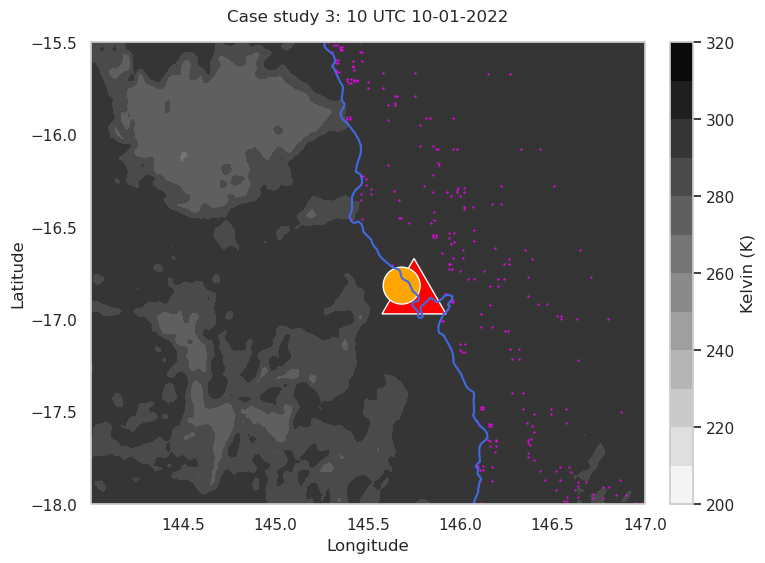

In [38]:
# snapshot plots
# def plot_snapshots():
#     timeslice = case_study_jam.time.sel(time=slice('2022-02-05T10:00:00.000000000','2022-02-15T10:00:00.000000000')).values 
#     for i in timeslice:
fig = plt.figure(figsize=(8,6))
fig.tight_layout()
fig.patch.set_facecolor('white')
sns.set_theme(style="whitegrid")
projPC = ccrs.PlateCarree()
ax = plt.subplot(1, 1, 1, projection=projPC)
snapshot = '2022-02-10T10:00:00' #str(i)
title = snapshot#str(i)#'2022-01-06T06:00:00'
x = case_study_jam.lon.values
y = case_study_jam.lat.values
z = case_study_jam.ch13BT.sel(time=snapshot) 
levels=np.arange(200,330,10)
cf = ax.contourf(x,y,z,levels=levels,cmap="binary")
cb = plt.colorbar(cf,fraction=0.046, pad=0.04) #ax=ax,
# plot gbr locations
ax.scatter(gbr_coordinates[:, 0], gbr_coordinates[:, 1], color='magenta', marker='o',s=0.3)
# ax.set_xlim(143,152)
ax.set_xlim(144,147)
# ax.set_ylim(-22,-14)
ax.set_ylim(-18,-15.5)
cb.set_label('Kelvin (K)')
# xtick = np.arange(143,153,1)
# ax.set_xticks(xtick)
# ytick = np.arange(-22,-13,1)
# ax.set_yticks(ytick)
xtick = np.arange(144.5,147.5,0.5)
ax.set_xticks(xtick)
ytick = np.arange(-18,-15,0.5)
ax.set_yticks(ytick)

ax.coastlines("10m",color="royalblue",linewidth=1.5)
ax.set_title('Case study 3: 10 UTC 10-01-2022',pad=15)
ax.set_xlabel("Longitude")
ax.set_ylabel('Latitude')
# circle_T = mpatches.Circle((146.5509,-19.4198),0.1,fc="orange") # Townsville
circle_C = mpatches.Circle((145.683,-16.817),0.1,fc="orange") # Cairns
# circle_W = mpatches.Circle((149.9646,-16.2874),0.1,fc="orange") # Willis Island
# circle_T_station = mpatches.RegularPolygon((146.77,-19.25), numVertices=3,radius=0.2,alpha=1,fc="red") # Townsville station
circle_C_station = mpatches.RegularPolygon((145.75,-16.87), numVertices=3,radius=0.2,alpha=1,fc="red") 
# ax.add_patch(circle_T_station)
ax.add_patch(circle_C_station)
# ax.add_patch(circle_T)
ax.add_patch(circle_C);
# ax.add_patch(circle_W);
        # plt.savefig("/home/563/ac9768/plots/case_study-jan/" + str(i) + ".png")
        # plt.close()
    # return
# plot_snapshots()

In [18]:
# convert UTC to LST
import datetime
import pytz
from datetime import datetime, timedelta
# Convert time to pandas datetime objects
time_values = pd.to_datetime(case_study_jam['time'].values,unit='ns')

# Define the longitude of the location (in degrees)
longitude = 145.6 # Cairns

# Convert nanoseconds to datetime objects in UTC
time_objects_utc = pd.to_datetime(time_values, unit='ns')

# Define the time zone for the location
local_timezone = pytz.timezone('Australia/Sydney')

# Convert UTC datetime objects to the local time zone
time_objects_local = time_objects_utc.tz_localize('UTC').tz_convert(local_timezone)

# Calculate the offset from UTC based on the longitude
# 4 minutes per degree of longitude from the prime meridian
longitude_offset = timedelta(minutes=(longitude / 360) * 60)

# Adjust the time to local solar time based on the longitude offset
time_objects_solar = time_objects_local - longitude_offset

# Format datetime objects as strings
time_strings_solar = time_objects_solar.strftime("%Y-%m-%d %H")

In [33]:
time_strings_solar

Index(['2022-01-01 10', '2022-01-01 11', '2022-01-01 12', '2022-01-01 13',
       '2022-01-01 14', '2022-01-01 15', '2022-01-01 16', '2022-01-01 17',
       '2022-01-01 18', '2022-01-01 19',
       ...
       '2022-03-31 23', '2022-04-01 00', '2022-04-01 02', '2022-04-01 03',
       '2022-04-01 04', '2022-04-01 05', '2022-04-01 06', '2022-04-01 07',
       '2022-04-01 08', '2022-04-01 09'],
      dtype='object', length=2055)

In [19]:
# update time in ds to local solar time
case_study_jam['time'] = time_strings_solar

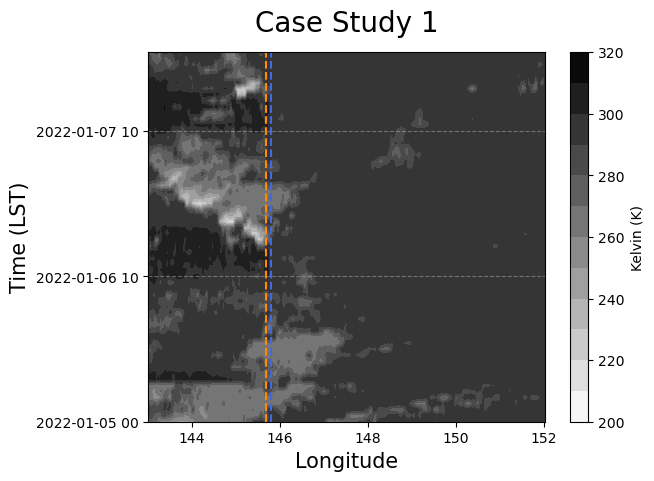

In [50]:
x = case_study_jam.isel(time=0).lon.values
sliced = slice('2022-01-04T23:00:00.000000000','2022-01-07T00:00:00.000000000')
y = case_study_jam.time.sel(time=sliced) #-16.817 #-19.4198
z = case_study_jam.ch13BT.sel(lat=-16.817,method="nearest").sel(time=sliced) # latitude is for the central Townsville radar site location
levels= np.arange(200,330,10)
cf = plt.contourf(x,y,z,levels=levels,cmap="binary")
cb = plt.colorbar(cf)
cb.set_label('Kelvin (K)')
site_lon = []
coast = []
lengthoftime = 62
for i in np.arange(0,lengthoftime,1):
    site_lon.append(145.683) #towns:146.5509) 
    coast.append(145.8) # towns: 147.5)
plt.axvline(145.683,linestyle='--',color='darkorange')
plt.axvline(145.8,color='royalblue',linestyle='--')
plt.title('Case Study 1',pad=15,fontsize=20)
plt.xlabel("Longitude",fontsize=15)
plt.grid(axis="y",linestyle='--',alpha=0.5)
plt.ylabel('Time (LST)',fontsize=15)
yticks = np.arange(0,62,24)
plt.yticks(yticks);

### Radar reflectivity

In [4]:
def path_to_radar_ds(radar_site_no,variable):
    """
    List of yyyymm (year+month) with available radar data.
    For each yyyymm create a list of entire file paths to netCDF4 files.

    Parameters:
    - radar_site_no (str): Radar site number- BoM ID's for radar locations: Townsville=73, Cairns=19, and Willis Island=41 

    Returns:
    - list: list object of netCDF4 files
    """
    # list = ["202201","202202","202203","202204",]
    list = ["202201","202202","202203","202204","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
           "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
          ] 
    files_list = []
    for i in list:
        fp = "/g/data/rq0/level_2/"+radar_site_no+"/"+variable+"/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return files_list

# towns_radar_files = path_to_radar_ds("73","REFLECTIVITY")
# cairns_radar_files = path_to_radar_ds("19","REFLECTIVITY")
cairns_radar_files = path_to_radar_ds("19","RAINRATE")
# willis_radar_files = path_to_radar_ds("41","REFLECTIVITY")

In [ ]:
%%time
def open_radar(file_path,threshold): 
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:
        ds_mean = ds.rainrate.mean(dim='time')
        masked_beam_blockage = xr.where((ds_mean < threshold), np.zeros_like(ds_mean),np.ones_like(ds_mean))
        mask_nonvalid_points = ~ds.rainrate.mean(dim='time').isnull()
        mask = masked_beam_blockage.where(mask_nonvalid_points)
        return mask
# reflectivity = open_radar(cairns_radar_files,"reflectivity")
# rr = open_radar(cairns_radar_files,1.2)
rr_test = open_radar(cairns_radar_files,1.2)

In [ ]:
%%time #test this
def open_radar(file_path,threshold): 
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:
        nan_to_zero = ds.rainrate.fillna(0)
        ds_mean = nan_to_zero.mean(dim='time')
        masked_beam_blockage = xr.where((ds_mean < threshold), np.zeros_like(ds_mean),np.ones_like(ds_mean))
        mask = masked_beam_blockage.where(masked_beam_blockage)
        return mask
# reflectivity = open_radar(cairns_radar_files,"reflectivity")
# rr = open_radar(cairns_radar_files,1.2)
rr_test = open_radar(cairns_radar_files,1.2)

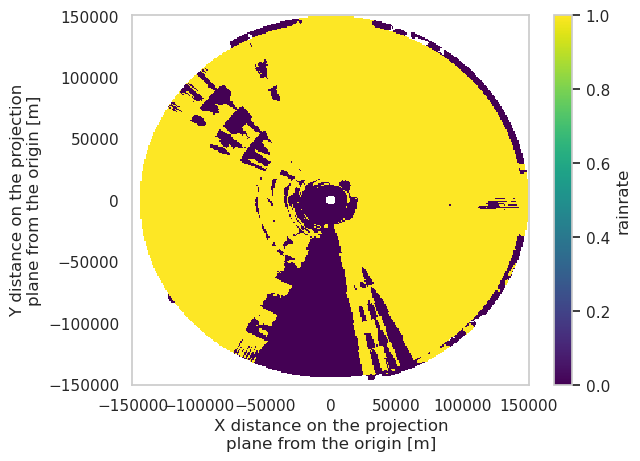

In [27]:
rr_test.plot()

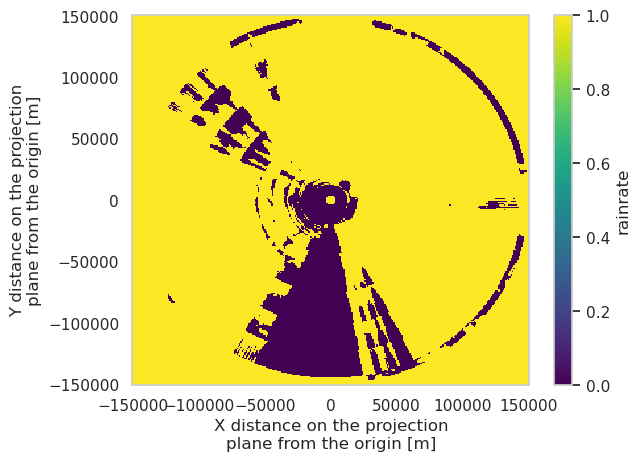

In [25]:
rr.plot()

In [20]:
%%time
def mask_rr(file_path,mask): 
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto").sel(time=slice('2022-01-05T10:00:00.000000000','2022-01-11T10:00:00.000000000')) as ds:
        masked_ds = ds.rainrate.where(mask)
        return masked_ds
masked_ds = mask_rr(cairns_radar_files,rr)

CPU times: user 1min 27s, sys: 1.36 s, total: 1min 28s
Wall time: 1min 39s


In [17]:
%%time
def ds_not_masked(file_path): 
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto").sel(time=slice('2022-02-05T10:00:00.000000000','2022-02-11T10:00:00.000000000')) as ds:
        return ds
plotting = ds_not_masked(cairns_radar_files)

CPU times: user 1min 16s, sys: 673 ms, total: 1min 16s
Wall time: 1min 17s


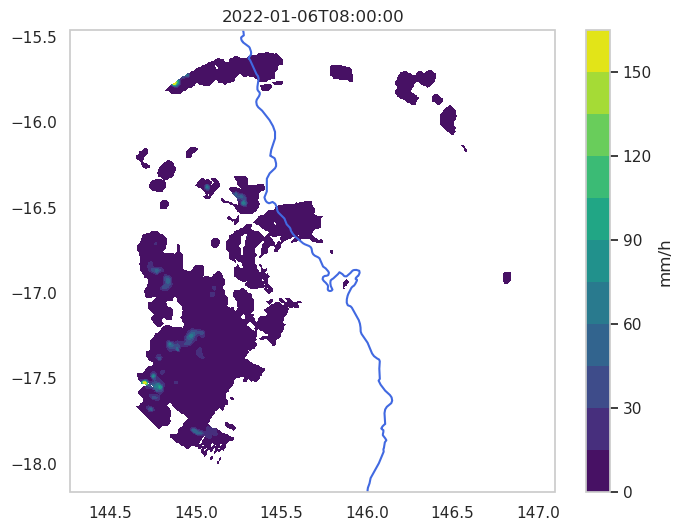

In [23]:
%%time
fig = plt.figure(figsize=(8,6))
fig.tight_layout()
fig.patch.set_facecolor('white')
sns.set_theme(style="whitegrid")
projPC = ccrs.PlateCarree()
ax = plt.subplot(1, 1, 1, projection=projPC)
time= "2022-01-06T08:00:00.000000000"
x = plotting.longitude.sel(time=time,method="nearest").values
y = plotting.latitude.sel(time=time,method="nearest").values
z = masked_ds.sel(time=time,method="nearest")
cf = ax.contourf(x,y,z,levels=10,cmap="viridis")
cb = plt.colorbar(cf,ax=ax)
cb.set_label("mm/h")
xtick = np.arange(144.5,147.5,0.5)
ax.set_xticks(xtick)
ytick = np.arange(-18,-15,0.5)
ax.set_yticks(ytick)
ax.coastlines("10m",color="royalblue",linewidth=1.5)
ax.grid(None)
ax.set_title(time[0:19]);